# 4.2 Word2Vec

먼저 책 내용을 따라한 후 파이토치로 구현해보자!

In [4]:
corpus_fname = '../data/tokenized/korquad_mecab.txt'
model_fname = '../data/word_embeddings/word2vec/word2vec'

from gensim.models import Word2Vec

In [5]:
%%time
corpus = [sent.strip().split(" ") for sent in open(corpus_fname, 'r', encoding='utf-8').readlines()]
model = Word2Vec(corpus, size=100, workers=4, sg=1)
model.save(model_fname)

Wall time: 39.7 s


In [40]:
model.wv('한글')

TypeError: 'Word2VecKeyedVectors' object is not callable

In [35]:
import os, sys
sys.path.append('F:\Google 드라이브\Programming\한국어 임베딩')

In [39]:
from models.word_eval import WordEmbeddingEvaluator
model = WordEmbeddingEvaluator('../data/word_embeddings/word2vec/word2vec',\
                              dim=100, tokenizer_name='mecab')

ModuleNotFoundError: No module named 'khaiii'

ValueError: attempted relative import beyond top-level package

에라이 망...

구현이나 해보자.
먼저 텍스트 데이터 생성부터 하자.

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [87]:
N = 3 # 윈도우 갯수
VEC_DIM = 100 # 임베딩 차원

In [3]:
txt_path = '../data/tokenized/korquad_mecab.txt'
corpus = [sent.strip().split() for sent in open(txt_path, 'r', encoding='utf-8').readlines()]

In [4]:
txt_path2 = '../data/tokenized/ratings_mecab.txt'
corpus2 = [sent.strip().split() for sent in open(txt_path2, 'r', encoding='utf-8').readlines()]

In [43]:
corpus_data = corpus# + corpus2

In [44]:
corpus_data[0]

['1',
 '8',
 '3',
 '9',
 '년',
 '바그너',
 '는',
 '괴테',
 '의',
 '파우스트',
 '을',
 '처음',
 '읽',
 '고',
 '그',
 '내용',
 '에',
 '마음',
 '이',
 '끌려',
 '이',
 '를',
 '소재',
 '로',
 '해서',
 '하나',
 '의',
 '교향곡',
 '을',
 '쓰',
 '려는',
 '뜻',
 '을',
 '갖',
 '는다',
 '.',
 '이',
 '시기',
 '바그너',
 '는',
 '1',
 '8',
 '3',
 '8',
 '년',
 '에',
 '빛',
 '독촉',
 '으로',
 '산전수전',
 '을',
 '다',
 '걲은',
 '상황',
 '이',
 '라',
 '좌절',
 '과',
 '실망',
 '에',
 '가득',
 '했으며',
 '메피스토펠레스',
 '를',
 '만나',
 '는',
 '파우스트',
 '의',
 '심경',
 '에',
 '공감',
 '했',
 '다고',
 '한다',
 '.',
 '또한',
 '파리',
 '에서',
 '아',
 '브네',
 '크',
 '의',
 '지휘',
 '로',
 '파리',
 '음악원',
 '관현악단',
 '이',
 '연주',
 '하',
 '는',
 '베토벤',
 '의',
 '교향곡',
 '9',
 '번',
 '을',
 '듣',
 '고',
 '깊',
 '은',
 '감명',
 '을',
 '받',
 '았',
 '는데',
 ',',
 '이것',
 '이',
 '이듬해',
 '1',
 '월',
 '에',
 '파우스트',
 '의',
 '서곡',
 '으로',
 '쓰여진',
 '이',
 '작품',
 '에',
 '조금',
 '이',
 '라도',
 '영향',
 '을',
 '끼쳤',
 '으리라는',
 '것',
 '은',
 '의심',
 '할',
 '여지',
 '가',
 '없',
 '다',
 '.',
 '여기',
 '의',
 '라단조',
 '조성',
 '의',
 '경우',
 '에',
 '도',
 '그',
 '의',
 '전기',
 '에',
 '적혀',
 '있',
 '는

In [45]:
vocab = set()
for i in range(len(corpus_data)):
    vocab.update(corpus_data[i])
    
print('단어 갯수 : ' + str(len(vocab)))

word_to_id = dict()
for word in vocab:
    word_to_id[word]=len(word_to_id)    
    
id_to_word = []
for word in word_to_id.keys():
    id_to_word.append(word)

단어 갯수 : 83593


In [46]:
corpus[1]

['바그너',
 '는',
 '괴테',
 '의',
 '파우스트',
 '를',
 '읽',
 '고',
 '무엇',
 '을',
 '쓰',
 '고자',
 '했',
 '는가',
 '?',
 '교향곡']

In [47]:
def sent_to_ngram(n, sent):
    ngrams = []
    
    for i in range(n, len(sent)-n):
        ngram = []
        for j in range(-n,n+1):
            ngram.append(sent[i+j])
        ngrams.append(ngram)
            
    return ngrams

In [88]:
sent_to_ngram(3,corpus[1])

[['바그너', '는', '괴테', '의', '파우스트', '를', '읽'],
 ['는', '괴테', '의', '파우스트', '를', '읽', '고'],
 ['괴테', '의', '파우스트', '를', '읽', '고', '무엇'],
 ['의', '파우스트', '를', '읽', '고', '무엇', '을'],
 ['파우스트', '를', '읽', '고', '무엇', '을', '쓰'],
 ['를', '읽', '고', '무엇', '을', '쓰', '고자'],
 ['읽', '고', '무엇', '을', '쓰', '고자', '했'],
 ['고', '무엇', '을', '쓰', '고자', '했', '는가'],
 ['무엇', '을', '쓰', '고자', '했', '는가', '?'],
 ['을', '쓰', '고자', '했', '는가', '?', '교향곡']]

In [89]:
train_data = []
for i in range(len(corpus_data)):
    train_data += sent_to_ngram(N, corpus_data[i])

In [90]:
def sent_to_vec(sent):
    vec = []
    for word in sent:
        vec.append(word_to_id[word])
    return vec

In [91]:
sent_to_ngram(3,corpus_data[1])[0]

['바그너', '는', '괴테', '의', '파우스트', '를', '읽']

In [92]:
sent_to_vec(train_data[0]),sent_to_vec(train_data[1])

([26494, 31901, 26200, 81583, 14801, 45264, 59443],
 [31901, 26200, 81583, 14801, 45264, 59443, 70316])

In [93]:
train_input = []
train_target = []
for data in train_data:
    train_input.append(sent_to_vec(data[:N])+sent_to_vec(data[N+1:]))
    train_target.append(word_to_id[data[N]])

In [94]:
train = torch.utils.data.TensorDataset(torch.tensor(train_input), torch.tensor(train_target))

CBOW 모델 생성

In [55]:
class CBOW(nn.Module):
    def __init__(self, vec_dim):
        super(CBOW,self).__init__()
        self.emb = nn.Embedding(len(vocab), vec_dim)
        self.lin = nn.Linear(vec_dim, len(vocab), bias=False)
        
    def forward(self, x):
        x = torch.mean(self.emb(x), dim=1)
        x = self.lin(x).view(-1,len(vocab))
        return x

In [95]:
model = CBOW(VEC_DIM)

In [96]:
loss_f = nn.CrossEntropyLoss()

In [97]:
model.to(dev)

CBOW(
  (emb): Embedding(83593, 100)
  (lin): Linear(in_features=100, out_features=83593, bias=False)
)

In [98]:
BATCH_SIZE = 128
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [99]:
input_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE)

In [100]:
check = 1000
epoch = 1

In [101]:
# GPU time
start = time.time()

loss_list = []

for epo in range(epoch):
    loss_sum = 0
    for i, (x, y) in enumerate(input_loader):

        x,y = x.to(dev), y.to(dev)
        optimizer.zero_grad()
        
        output = model(x)
        
        loss = loss_f(output, y)
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        
        
        if i % check == 0:        
            elap = int(time.time() - start)
            loss_list.append(loss_sum/check)
            print('Epoch : {}, Iteration : {}, Loss : {:.2f}, Elapsed time : {:.0f}h {:.0f}m {}s'.format(\
                epo, i, loss_sum / check, elap // 3600, (elap % 3600) // 60, str(int((elap % 3600) % 60))))
            loss_sum = 0

Epoch : 0, Iteration : 0, Loss : 0.01, Elapsed time : 0h 0m 0s
Epoch : 0, Iteration : 1000, Loss : 6.90, Elapsed time : 0h 0m 18s
Epoch : 0, Iteration : 2000, Loss : 6.76, Elapsed time : 0h 0m 37s
Epoch : 0, Iteration : 3000, Loss : 6.66, Elapsed time : 0h 0m 56s
Epoch : 0, Iteration : 4000, Loss : 6.46, Elapsed time : 0h 1m 15s
Epoch : 0, Iteration : 5000, Loss : 6.39, Elapsed time : 0h 1m 34s
Epoch : 0, Iteration : 6000, Loss : 6.29, Elapsed time : 0h 1m 53s
Epoch : 0, Iteration : 7000, Loss : 6.30, Elapsed time : 0h 2m 12s
Epoch : 0, Iteration : 8000, Loss : 6.31, Elapsed time : 0h 2m 31s
Epoch : 0, Iteration : 9000, Loss : 6.32, Elapsed time : 0h 2m 50s
Epoch : 0, Iteration : 10000, Loss : 6.05, Elapsed time : 0h 3m 8s
Epoch : 0, Iteration : 11000, Loss : 5.86, Elapsed time : 0h 3m 27s
Epoch : 0, Iteration : 12000, Loss : 6.04, Elapsed time : 0h 3m 46s
Epoch : 0, Iteration : 13000, Loss : 6.02, Elapsed time : 0h 4m 4s
Epoch : 0, Iteration : 14000, Loss : 5.98, Elapsed time : 0h 4m 

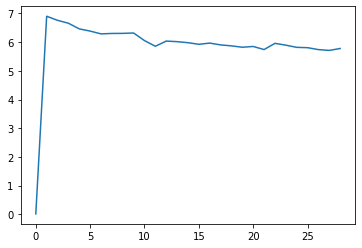

In [102]:
plt.plot(loss_list)

In [103]:
save_path = 'CBOW_N3_1epoch.pt'#.format(epoch)
torch.save(model.state_dict(), save_path)

In [21]:
path = 'CBOW_5epoch.pt'
model = CBOW(VEC_DIM)
model.load_state_dict(torch.load(path))
model.eval()

CBOW(
  (emb): Embedding(114937, 100)
  (lin): Linear(in_features=100, out_features=114937, bias=False)
)

In [104]:
def similar_words(model, word, k=10):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    
    word_id = torch.tensor([word_to_id[word]])
    word_vec = model.emb(word_id)
    word_mat = next(iter(model.emb.parameters())).detach()
    
    cos_mat = cos(word_vec, word_mat)
    sim, indices = torch.topk(cos_mat,k+1)
    
    
    word_list = []
    for i in indices:
        if i != word_id:
            word_list.append(id_to_word[i])
    return word_list, sim[1:].detach()

In [180]:
similar_words(model.to('cpu'), '지역')

(['곳', '시장', '민족', '구간', '빌리치', '영역', '지방', '나라', '간담', '붕당'],
 tensor([0.6377, 0.5033, 0.4792, 0.4789, 0.4776, 0.4514, 0.4473, 0.4390, 0.4388,
         0.4383]))

In [181]:
similar_words(model.to('cpu'), '어머니')

(['아버지', '아내', '그녀', '크기', '진정서', '인제', '피해자', '엄마', '정부', '세조'],
 tensor([0.5977, 0.5660, 0.5630, 0.5254, 0.5107, 0.4938, 0.4917, 0.4824, 0.4766,
         0.4732]))

In [182]:
similar_words(model.to('cpu'), '대한민국')

(['일본', '한국', '미국', '우라야스', '자국', '중국', '에스토니아', '왜관', 'Στίλβων', '대부분'],
 tensor([0.5484, 0.4867, 0.4831, 0.4346, 0.4197, 0.4153, 0.4115, 0.4053, 0.4029,
         0.4027]))

In [183]:
similar_words(model.to('cpu'), '컴퓨터')

(['정보', '캐릭터', '성능', '예물', '상식', '가치', '인터페이스', '변화', '으신다', '병리'],
 tensor([0.4606, 0.4514, 0.4488, 0.4450, 0.4408, 0.4169, 0.4166, 0.4081, 0.4036,
         0.4032]))

In [ ]:
similar_words(model.to('cpu'), '')

In [111]:
def analogy(model, word1, word2, word3,k=10):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    
    word_id1 = torch.tensor([word_to_id[word1]])
    word_id2 = torch.tensor([word_to_id[word2]])
    word_id3 = torch.tensor([word_to_id[word3]])
    word_vec1 = model.emb(word_id1)
    word_vec2 = model.emb(word_id2)
    word_vec3 = model.emb(word_id3)
    word_mat = next(iter(model.emb.parameters())).detach()
    
    cos_mat = cos(word_vec1-word_vec2+word_vec3, word_mat)
    sim, indices = torch.topk(cos_mat,k)
    
    
    word_list = []
    for i in indices:
        word_list.append(id_to_word[i])
    return word_list, sim[1:].detach()

In [112]:
analogy(model,'한국','서울','파리')

(['파리', '한국', '참전', '산량', '입대', '사염', '걸쳐서', '프랑스와', '달했으며', '발매되'],
 tensor([0.5320, 0.5006, 0.3921, 0.3908, 0.3891, 0.3889, 0.3769, 0.3733, 0.3731]))

In [113]:
analogy(model,'왕','남자','여자')

(['왕', '동반성', '합당', '신탁', '핀란드어', '왕위', '여자', '와이드', '크시슈토프', '콜먼'],
 tensor([0.4096, 0.4065, 0.4057, 0.3908, 0.3795, 0.3704, 0.3678, 0.3669, 0.3643]))

N=5 일때보다 N=3 으로 하니까 뭔가 잘되는 느낌...
이제 skip-gram으로 해보자.

### 이번엔 Skip-gram 모델...

먼저 훈련데이터 형식을 [중심단어, 문맥단어] 으로 바꾸자.

In [127]:
%%time
train_input = []
train_target = []
for data in train_data:
    target = sent_to_vec(data[:N])+sent_to_vec(data[N+1:])
    for i in range(len(target)):
        train_input.append(word_to_id[data[N]])
        train_target.append(target[i])


Wall time: 15.2 s


In [128]:
train_data[0], train_data[1]

(['1', '8', '3', '9', '년', '바그너', '는'], ['8', '3', '9', '년', '바그너', '는', '괴테'])

In [129]:
sent_to_vec(train_data[0])

[26494, 31901, 26200, 81583, 14801, 45264, 59443]

In [132]:
train_input[0], train_target[0]

(81583, 26494)

In [133]:
len(train_input), len(train_target)

(21793818, 21793818)

In [134]:
train = torch.utils.data.TensorDataset(torch.tensor(train_input), torch.tensor(train_target))

In [135]:
emb = nn.Embedding(len(vocab), VEC_DIM)
lin = nn.Linear(VEC_DIM, len(vocab), bias=False)

In [156]:
BATCH_SIZE=128
input_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

In [145]:
class Skipgram(nn.Module):
    def __init__(self, vec_dim):
        super(Skipgram,self).__init__()
        self.emb = nn.Embedding(len(vocab), vec_dim)
        self.lin = nn.Linear(vec_dim, len(vocab), bias=False)
        
    def forward(self, x):
        x = self.emb(x)
        x = self.lin(x)#.view(-1,len(vocab))
        return x

In [157]:
model_sg = Skipgram(VEC_DIM).to(dev)

In [158]:
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_sg.parameters(), lr=0.01)

In [170]:
check = 5000
epoch = 2

In [172]:
model_sg.to(dev)

Skipgram(
  (emb): Embedding(83593, 100)
  (lin): Linear(in_features=100, out_features=83593, bias=False)
)

In [173]:
# GPU time
start = time.time()

#loss_list = []

for epo in range(epoch):
    loss_sum = 0
    for i, (x, y) in enumerate(input_loader):

        x,y = x.to(dev), y.to(dev)
        optimizer.zero_grad()
        
        output = model_sg(x)
        
        loss = loss_f(output, y)
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        
        
        if i % check == 0:        
            elap = int(time.time() - start)
            loss_list.append(loss_sum/check)
            print('Epoch : {}, Iteration : {}, Loss : {:.2f}, Elapsed time : {:.0f}h {:.0f}m {}s'.format(\
                epo, i, loss_sum / check, elap // 3600, (elap % 3600) // 60, str(int((elap % 3600) % 60))))
            loss_sum = 0

Epoch : 0, Iteration : 0, Loss : 0.00, Elapsed time : 0h 0m 1s
Epoch : 0, Iteration : 5000, Loss : 7.39, Elapsed time : 0h 1m 33s
Epoch : 0, Iteration : 10000, Loss : 7.40, Elapsed time : 0h 3m 6s
Epoch : 0, Iteration : 15000, Loss : 7.40, Elapsed time : 0h 4m 39s
Epoch : 0, Iteration : 20000, Loss : 7.39, Elapsed time : 0h 6m 11s
Epoch : 0, Iteration : 25000, Loss : 7.40, Elapsed time : 0h 7m 41s
Epoch : 0, Iteration : 30000, Loss : 7.39, Elapsed time : 0h 9m 13s
Epoch : 0, Iteration : 35000, Loss : 7.38, Elapsed time : 0h 10m 45s
Epoch : 0, Iteration : 40000, Loss : 7.38, Elapsed time : 0h 12m 18s
Epoch : 0, Iteration : 45000, Loss : 7.36, Elapsed time : 0h 13m 51s
Epoch : 0, Iteration : 50000, Loss : 7.36, Elapsed time : 0h 15m 24s
Epoch : 0, Iteration : 55000, Loss : 7.36, Elapsed time : 0h 16m 57s
Epoch : 0, Iteration : 60000, Loss : 7.36, Elapsed time : 0h 18m 30s
Epoch : 0, Iteration : 65000, Loss : 7.35, Elapsed time : 0h 20m 3s
Epoch : 0, Iteration : 70000, Loss : 7.35, Elapse

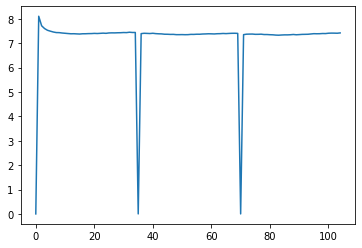

In [174]:
plt.plot(loss_list)

In [175]:
save_path = 'SG_N3_3epoch.pt'#.format(epoch)
torch.save(model_sg.state_dict(), save_path)

In [176]:
similar_words(model_sg.to('cpu'), '지역')

(['과', '유아사', '득실거리', '보모', '지코', '김정화', '검찰청', '속하', '장소', '지금'],
 tensor([0.5190, 0.4759, 0.4567, 0.4330, 0.4231, 0.4205, 0.4199, 0.4187, 0.4139,
         0.4085]))

In [177]:
similar_words(model_sg.to('cpu'), '어머니')

(['선조', '그', '백록', '장기하', '하치조', '오스', '루시', '에른스트', '아이', '데뷔작'],
 tensor([0.4927, 0.4756, 0.4455, 0.4180, 0.4145, 0.4031, 0.3993, 0.3988, 0.3967,
         0.3941]))

In [178]:
similar_words(model_sg.to('cpu'), '대한민국')

(['및', '년', '아시아', '병력', '5', '선거', '본부', '인천', '7', '론'],
 tensor([0.4887, 0.4550, 0.4481, 0.4243, 0.4039, 0.4027, 0.3944, 0.3941, 0.3936,
         0.3915]))

In [179]:
similar_words(model_sg.to('cpu'), '컴퓨터')

(['에볼라', '고래', '부분', '윔', '느낀다는', '스몰', '인화물', '편곡', '초신성', '아이템'],
 tensor([0.4224, 0.4050, 0.3938, 0.3918, 0.3844, 0.3837, 0.3787, 0.3598, 0.3581,
         0.3569]))

In [169]:
analogy(model_sg,'한국','서울','파리')

(['파리', '원정', '한국', '바이크', '벌목', '사이펀', '겨우', '박신양', '동부', '허물'],
 tensor([0.4750, 0.4459, 0.4239, 0.4016, 0.3893, 0.3867, 0.3844, 0.3778, 0.3735]))